In [3]:
import os
import pprint
import tempfile

from typing import Dict, Text

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [4]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"]
})
movies = movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\trung\tensorflow_datasets\movielens\100k-ratings\0.1.1.incompleteIDZX55\movielens-train.tfr…

Dataset movielens downloaded and prepared to C:\Users\trung\tensorflow_datasets\movielens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\trung\tensorflow_datasets\movielens\100k-movies\0.1.1.incompleteMNIJUT\movielens-train.tfre…

Dataset movielens downloaded and prepared to C:\Users\trung\tensorflow_datasets\movielens\100k-movies\0.1.1. Subsequent calls will reuse this data.


In [7]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [8]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(
    np.concatenate(
        list(ratings.batch(1_000).map(lambda x: x["user_id"]))
    )
)

In [9]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )

        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
        ], axis=1)


class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # First use the user model for generating embeddings
        self.embedding_model = UserModel()

        # Then construct the layers
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)


class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
              vocabulary=unique_movie_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])

        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)


class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # First use the movie model for generating embeddings
        self.embedding_model = MovieModel()

        # Then construct the layers
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)


class MovielensModel(tfrs.models.Model):

    def __init__(self, layer_sizes: float, rating_weight: float, retrieval_weight: float) -> None:
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(1),
        ])
        # The tasks
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model)
            )
        )
        # The loss weights
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight
        
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # Pick out the user features and pass them into the user model
        user_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"]
        })
        # Pick out the movie features and pass them into the movie model
        movie_embeddings = self.candidate_model(features["movie_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # Apply the multi-layered rating model to a concatentation of
            # user and movie embeddings
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            )
        )

    def compute_loss(self, features, training=False):

        ratings = features.pop("user_rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # Compute the loss for each task
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings, compute_metrics=not training)

        # Combine them using the loss weights
        return (
            self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss
        )

In [10]:
model = MovielensModel(layer_sizes=[64, 32], rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=50,
    verbose=0
)

accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
root_mean_squared_error = history.history["val_root_mean_squared_error"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")
print(f"Ranking RMSE: {root_mean_squared_error:.2f}.")

Top-100 accuracy: 0.24.
Ranking RMSE: 1.03.


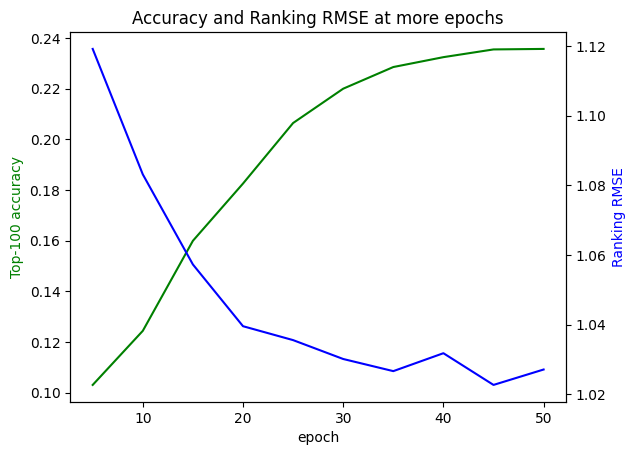

In [11]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], 'g-')
ax2.plot(epochs, history.history["val_root_mean_squared_error"], 'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Top-100 accuracy', color='g')
ax2.set_ylabel('Ranking RMSE', color='b')

plt.title("Accuracy and Ranking RMSE at more epochs")
plt.show()

In [17]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
    "user_id": np.array(["1"]),
    "movie_title": np.array(["Pulp Fiction"]),
    "timestamp": np.array([893286638])
})
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[4.2403173]], shape=(1, 1), dtype=float32)
